In [ ]:
"""
Purpose: To practice width jump proofreading on neurons

"""

In [1]:
from os import sys
sys.path.append("/meshAfterParty/")

In [2]:
from importlib import reload
import os
from pathlib import Path
import neuron_utils as nru
nru = reload(nru)
import neuron
neuron=reload(neuron)
import neuron_visualizations as nviz
import time
import system_utils as su
import datajoint_utils as du
import datajoint as dj

INFO - 2020-11-26 22:57:12,210 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2020-11-26 22:57:12,211 - settings - Setting database.user to celiib
INFO - 2020-11-26 22:57:12,212 - settings - Setting database.password to newceliipass


# Importing the Neuron To Test

In [3]:
import neuron_visualizations as nviz
curr_seg_id = 864691134884742394
minnie,schema = du.configure_minnie_vm()

INFO - 2020-11-26 22:57:15,593 - settings - Setting stores to {'minnie65': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65', 'stage': '/mnt/dj-stor01/platinum/minnie65'}, 'meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/meshes'}, 'decimated_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes'}, 'skeletons': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/skeletons'}}
INFO - 2020-11-26 22:57:15,594 - settings - Setting enable_python_native_blobs to True
INFO - 2020-11-26 22:57:15,607 - connection - Connected celiib@at-database.ad.bcm.edu:3306
INFO - 2020-11-26 22:57:15,792 - settings - Setting enable_python_native_blobs to True


Connecting celiib@at-database.ad.bcm.edu:3306


In [4]:
neuron_obj = (minnie.Decomposition() & dict(segment_id=curr_seg_id)).fetch1("decomposition")

INFO - 2020-11-26 22:57:21,910 - settings - Setting enable_python_native_blobs to True
INFO - 2020-11-26 22:57:22,078 - settings - Setting enable_python_native_blobs to True


Decompressing Neuron in minimal output mode...please wait


In [5]:
ret_col = nviz.visualize_neuron(neuron_obj,
                     visualize_type=["mesh","skeleton"],
                     limb_branch_dict=dict(L0="all"),
                     return_color_dict=True)


 Working on visualization type: mesh

 Working on visualization type: skeleton
Working on  new stand alone scatter points


# Testing how many branches would fail based on width jump

In [6]:
neuron = reload(neuron)
nru = reload(nru)
nviz = reload(nviz)
neuron_obj = neuron.Neuron(neuron_obj)

Recieved another instance of Neuron class in init -- so just copying data


No limb name was given so using L0 because was the limb in the first key


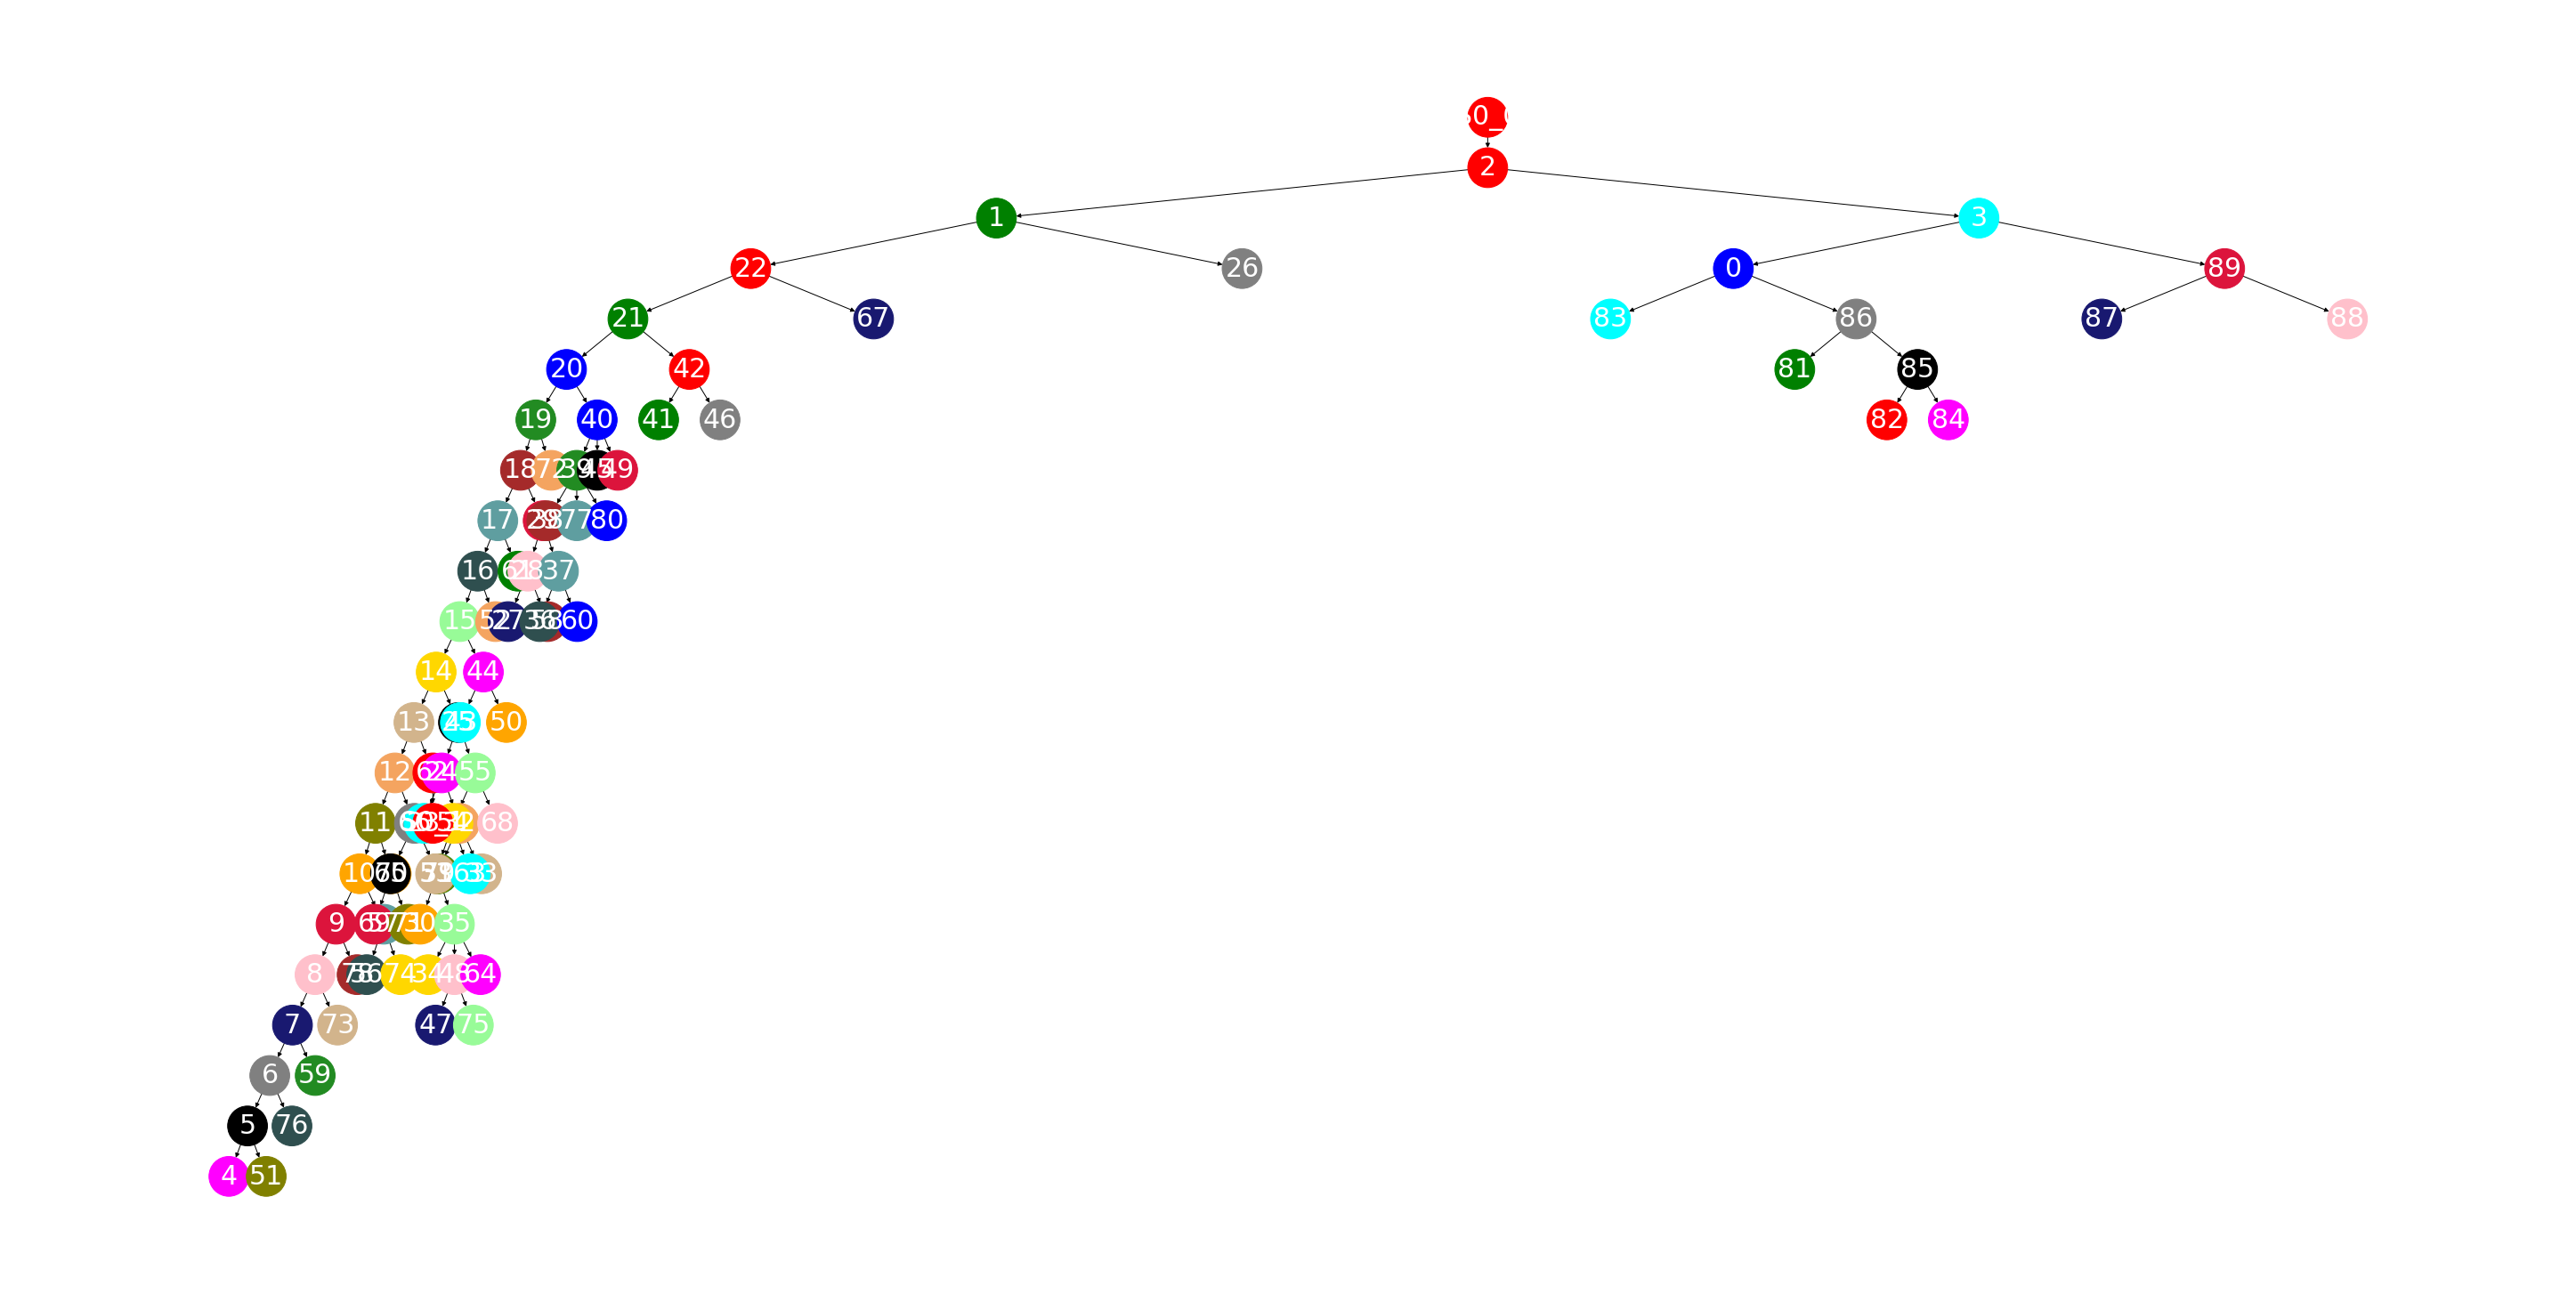

In [7]:
nviz = reload(nviz)
nviz.plot_limb_concept_network_2D(neuron_obj,node_colors=ret_col,
                                 pos_width=10)

In [8]:
import width_utils as wu
from copy import deepcopy
import numpy as np

In [9]:
curr_limb_idx = 0
curr_limb = neuron_obj[curr_limb_idx]
curr_limb_copy = deepcopy(curr_limb)

In [ ]:
"""
Notes on the width jump:

over 100 not uncommon

Valid width jump: (332.3374621295012, 166.23333195975843)

Think the only rule is it can't really jump up

Fine jump: 
(133.57307832937653, 181.66114820214048)
(133.57307832937653, 109.92615494285452)

"""

In [113]:
import error_detection as ed

In [46]:
curr_limb

False

In [111]:
"""
For each soma group in all_concept_network
Go through all of the edges in the directional concept network: 
1) Get the width jump of that edge
2) If it jumps above perscribed amount save the edge
"""


nru = reload(nru)
import time
import copy
def width_jump_edges(limb,
                    width_type = "no_spine_median_mesh_center",
                     width_jump_threshold = 100,
                     verbose=False
                    ):
    """
    Will only look to see if the width jumps up by a width_jump_threshold threshold ammount
    and if it does then will save the edges according to that starting soma group
    """
    curr_limb_cp = copy.deepcopy(limb)


    width_start_time = time.time()
    verbose = True

    error_edges = dict()
    for k in curr_limb.all_concept_network_data:
        curr_soma = k["starting_soma"]
        curr_soma_group = k["soma_group_idx"]
        
        
        curr_limb.set_concept_network_directional(starting_soma=curr_soma,
                                                 soma_group_idx=curr_soma_group)
        curr_net = curr_limb.concept_network_directional
        print(f"curr_limb.current_starting_node = {curr_limb.current_starting_node}")

        if verbose: 
            print(f'Working on soma group {k["soma_group_idx"]}')

        curr_error_edges = []
        for current_nodes in curr_net.edges():
            print(f"  Edge: {current_nodes}")
    #         width_array_1,width_array_2 = wu.find_mesh_width_array_border(curr_limb=curr_limb_cp,
    #                                          node_1 = current_nodes[0],
    #                                          node_2 = current_nodes[1],
    #                                         width_name=width_type,
    #                                         segment_start = 1,
    #                                         segment_end = 3,
    #                                         #skeleton_segment_size = 500,
    #                                         print_flag=False,
    #                                         )

            up_width,d_width,up_sk,d_sk = nru.branch_boundary_transition(curr_limb_cp,
                                  edge=current_nodes,
                                #offset=0,
                                verbose=False)

            downstream_jump = d_width-up_width

            if downstream_jump > width_jump_threshold:
                curr_error_edges.append(list(current_nodes))
        
        if curr_soma not in error_edges.keys():
            error_edges[curr_soma] = dict()
        error_edges[curr_soma][curr_soma_group] = curr_error_edges
        
    if verbose: 
        print(f"Total time for width = {time.time() - width_start_time}")
    return error_edges
    


In [29]:
up_width,d_width,up_sk,d_sk = nru.branch_boundary_transition(curr_limb_cp,
                              edge=[1,2],
                            #offset=0,
                            verbose=False)
up_width,d_width

(413.5374757598598, 704.0694409336846)

In [34]:
curr_limb[2].width_array[width_type]

array([766.34705857, 641.69683805, 522.85190817])

# Visualizing Results from New Width Test

In [107]:
nru = reload(nru)
nviz = reload(nviz)

In [108]:
#curr_errors = np.array(error_edges[0])[:,0]
error_edges_idx = 1
curr_errors = np.array(error_edges[error_edges_idx]).ravel() #visualizing culprit and causing
curr_errors = [1]

highlight_color = [1,0,0,1]
nviz.visualize_neuron(neuron_obj,
                      visualize_type=["mesh","skeleton","network"],
                     limb_branch_dict=dict(L0="all"),
                      #mesh_color={"L0":dict([(k,highlight_color) for k in curr_errors])},
                      mesh_color = "green",
                      mesh_fill_color="green",
                      skeleton_color="green",
                      skeleton_fill_color="green",
                      
                      
                     )


 Working on visualization type: mesh

 Working on visualization type: skeleton

 Working on visualization type: network
---Working on soma: 0, group = 0
---Working on soma: 0, group = 1
attrs = {62: {'starting_coordinate': array([883192.09948913, 743523.79014019, 611188.81171996])}}
current network edges = (AtlasView({'L0_16': {}, 'L0_61': {}, 'L0_18': {}}), AtlasView({'L0_19': {}, 'L0_40': {}, 'L0_21': {}}))
---Working on soma: 0, group = 0
current network edges = (AtlasView({'L0_16': {}, 'L0_61': {}, 'L0_18': {}}), AtlasView({'L0_19': {}, 'L0_40': {}, 'L0_21': {}}))
---Working on soma: 0, group = 0
current network edges = (AtlasView({'L0_16': {}, 'L0_61': {}, 'L0_18': {}}), AtlasView({'L0_19': {}, 'L0_40': {}, 'L0_21': {}}))
---Working on soma: 0, group = 0
current network edges = (AtlasView({'L0_16': {}, 'L0_61': {}, 'L0_18': {}}), AtlasView({'L0_19': {}, 'L0_40': {}, 'L0_21': {}}))
---Working on soma: 0, group = 0
current network edges = (AtlasView({'L0_16': {}, 'L0_61': {}, 'L0_1

In [102]:
nru = reload(nru)
returned_network = nru.whole_neuron_branch_concept_network(neuron_obj,
                                       directional=True,
                                       )

---Working on soma: 0, group = 0
---Working on soma: 0, group = 1
attrs = {62: {'starting_coordinate': array([883192.09948913, 743523.79014019, 611188.81171996])}}
current network edges = (AtlasView({'L0_16': {}, 'L0_61': {}, 'L0_18': {}}), AtlasView({'L0_19': {}, 'L0_40': {}, 'L0_21': {}}))
---Working on soma: 0, group = 0
current network edges = (AtlasView({'L0_16': {}, 'L0_61': {}, 'L0_18': {}}), AtlasView({'L0_19': {}, 'L0_40': {}, 'L0_21': {}}))
---Working on soma: 0, group = 0
current network edges = (AtlasView({'L0_16': {}, 'L0_61': {}, 'L0_18': {}}), AtlasView({'L0_19': {}, 'L0_40': {}, 'L0_21': {}}))
---Working on soma: 0, group = 0
current network edges = (AtlasView({'L0_16': {}, 'L0_61': {}, 'L0_18': {}}), AtlasView({'L0_19': {}, 'L0_40': {}, 'L0_21': {}}))
---Working on soma: 0, group = 0
current network edges = (AtlasView({'L0_16': {}, 'L0_61': {}, 'L0_18': {}}), AtlasView({'L0_19': {}, 'L0_40': {}, 'L0_21': {}}))


In [96]:
curr_limb = neuron_obj[0]

In [97]:
curr_limb.set_concept_network_directional(0,0)

In [98]:
neuron_obj[0].concept_network_directional[2]

AtlasView({1: {}, 3: {}})